In [1]:
# project: p6
# submitter: zzhou443
# partner: none
# hours: 7

In [2]:
import geopandas as gpd
from sklearn.linear_model import LinearRegression

In [3]:
#Q1: How many counties are in Wisconsin?
gdf = gpd.read_file("counties.geojson")
len(gdf.NAME)

72

<AxesSubplot:>

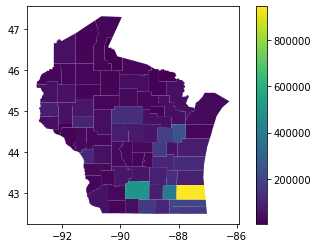

In [4]:
#Q2: What is the population of each county in WI?
import matplotlib.pyplot as plt
gdf.plot(column = "POP100", legend = True)

In [5]:
import sqlite3, os
import pandas as pd

In [6]:
conn = sqlite3.connect("counties_tracts.db")

In [7]:
pd.read_sql("""SELECT * FROM sqlite_master""", conn)

,type,name,tbl_name,rootpage,sql
0,table,counties,counties,2,"CREATE TABLE ""counties"" (\n""index"" INTEGER,\n ..."
1,index,ix_counties_index,counties,3,"CREATE INDEX ""ix_counties_index""ON ""counties"" ..."
2,table,tracts,tracts,4,"CREATE TABLE ""tracts"" (\n""index"" INTEGER,\n ""..."
3,index,ix_tracts_index,tracts,5,"CREATE INDEX ""ix_tracts_index""ON ""tracts"" (""in..."


In [8]:
arealand = pd.read_sql("""SELECT AREALAND FROM counties""", conn)
gdf["AREALAND"] = arealand

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
train, test = train_test_split(gdf, random_state=320, test_size=0.25)

In [11]:
#Q3
list(test["NAME"])

['Kewaunee County',
 'Calumet County',
 'Adams County',
 'Eau Claire County',
 'Milwaukee County',
 'Ashland County',
 'Wood County',
 'Dodge County',
 'Sauk County',
 'Clark County',
 'Pepin County',
 'Taylor County',
 'Iron County',
 'Outagamie County',
 'Florence County',
 'Oneida County',
 'Pierce County',
 'Grant County']

In [12]:
#q4
model = LinearRegression()
model.fit(train[["AREALAND"]], train["POP100"])
model.score(test[["AREALAND"]], test["POP100"])

0.022002661530554857

In [13]:
#Q5: What is the predicted population of a county with 500 square miles of area, according to the model?
num_500 = 1e6 * 500 * 2.59
num_500

model.predict([[num_500]])[0]


/home/zhouzejun/.local/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


82032.53073541154

In [14]:
tracts = pd.read_sql("""SELECT * FROM tracts""", conn)

In [15]:
total_hu100 = tracts.groupby(["COUNTY"])["HU100"].sum()

In [16]:
county_id = pd.read_sql("""SELECT * FROM counties""", conn)["COUNTY"] ## id of counties in order

In [17]:
total_hu100

COUNTY
001     17436
003      9656
005     23614
007     12999
009    104371
        ...  
133    160864
135     25396
137     14843
139     73329
141     34088
Name: HU100, Length: 72, dtype: int64

In [18]:
dic = {}
for j in county_id:
    for i in total_hu100.index:
        if i == j:
            dic[j] = total_hu100.loc[i]

In [19]:
gdf["HU100"] = dic.values()
gdf["COUNTY"] = dic.keys()

In [20]:
train_hu100, test_hu100 = train_test_split(gdf, random_state=320, test_size=0.25)

In [21]:
#q6
list(test_hu100["NAME"])

['Kewaunee County',
 'Calumet County',
 'Adams County',
 'Eau Claire County',
 'Milwaukee County',
 'Ashland County',
 'Wood County',
 'Dodge County',
 'Sauk County',
 'Clark County',
 'Pepin County',
 'Taylor County',
 'Iron County',
 'Outagamie County',
 'Florence County',
 'Oneida County',
 'Pierce County',
 'Grant County']

In [22]:
#q7
train_hu100[["NAME", "HU100"]].set_index("NAME").to_dict()["HU100"]

{'Walworth County': 51531,
 'Marquette County': 9896,
 'Racine County': 82164,
 'Waupaca County': 25396,
 'Lincoln County': 16784,
 'Washburn County': 12979,
 'Door County': 23966,
 'Waukesha County': 160864,
 'Sheboygan County': 50766,
 'La Crosse County': 48402,
 'Langlade County': 12360,
 'Marathon County': 57734,
 'Jefferson County': 35147,
 'Price County': 11120,
 'Vilas County': 25116,
 'Columbia County': 26137,
 'Ozaukee County': 36267,
 'Fond du Lac County': 43910,
 'Crawford County': 8802,
 'Lafayette County': 7230,
 'Green County': 15856,
 'Marinette County': 30379,
 'Vernon County': 13720,
 'Douglas County': 22825,
 'Rock County': 68422,
 'Iowa County': 10719,
 'Dane County': 216022,
 'Bayfield County': 12999,
 'Polk County': 24248,
 'Trempealeau County': 12619,
 'Brown County': 104371,
 'Washington County': 54695,
 'Chippewa County': 27185,
 'Oconto County': 23537,
 'Richland County': 8868,
 'Portage County': 30054,
 'Sawyer County': 15975,
 'Menominee County': 2253,
 'Barr

In [23]:
from sklearn.model_selection import cross_val_score

In [24]:
#q8
model = LinearRegression()
model.fit(train_hu100[["HU100"]], train_hu100["POP100"])
cross_val_score(model, train_hu100[["HU100"]], train_hu100["POP100"]).mean()

0.9652534544116037

In [25]:
#q9
cross_val_score(model, train_hu100[["HU100"]], train_hu100["POP100"]).std()

0.03704265206670459

In [26]:
#q10
slope = round(model.coef_[0], 2)
y_inter = round(model.intercept_, 2)
"POP100 = " + str(slope) + "*HU100" + " " + "+ " + str(y_inter)

'POP100 = 2.39*HU100 + -7910.46'

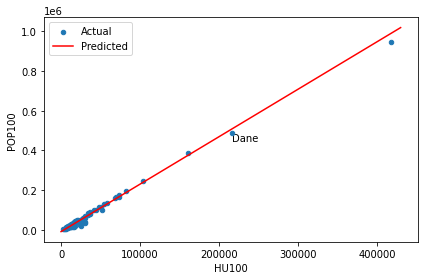

In [27]:
#Q11: What is the relationship between HU100 and POP100, visually?
predict_df = pd.DataFrame({"HU100":range(430000)})
predict_df["POP100"] = model.predict(predict_df[["HU100"]])
ax1 = gdf.plot.scatter(x = "HU100", y = "POP100")
ax2 = predict_df.plot.line(x = "HU100", y = "POP100", xticks = [0, 100000, 200000, 300000, 400000], color = "red", ax = ax1)
plt.legend(["Actual", "Predicted"])
x_c = gdf[gdf["NAME"] == "Dane County"]["HU100"]
y_c = gdf[gdf["NAME"] == "Dane County"]["POP100"]
ax2.text(x_c, y_c, "Dane", zorder = -1, va = "top", ha = "left")
plt.tight_layout()


In [28]:
import numpy as np

In [29]:
A = np.array([
    [0,0,5,8,4],
    [1,2,4,0,3],
    [2,4,0,9,2],
    [3,5,2,1,1],
    [0,5,0,1,0]
])

In [30]:
res = A [ (A >=2) & (A <= 5)]

In [31]:
#q12
len(res)

12

In [32]:
import rasterio
land = rasterio.open("zip:land.zip!wi.tif")

In [33]:
url = "https://tigerweb.geo.census.gov/arcgis/rest/services/TIGERweb/tigerWMS_Census2020/MapServer/82/query?where=NAME%3D%27Dane+County%27&text=&objectIds=&time=&geometry=&geometryType=esriGeometryEnvelope&inSR=&spatialRel=esriSpatialRelIntersects&distance=&units=esriSRUnit_Foot&relationParam=&outFields=&returnGeometry=true&returnTrueCurves=false&maxAllowableOffset=&geometryPrecision=&outSR=&havingClause=&returnIdsOnly=false&returnCountOnly=false&orderByFields=&groupByFieldsForStatistics=&outStatistics=&returnZ=false&returnM=false&gdbVersion=&historicMoment=&returnDistinctValues=false&resultOffset=&resultRecordCount=&returnExtentOnly=false&datumTransformation=&parameterValues=&rangeValues=&quantizationParameters=&featureEncoding=esriDefault&f=geojson"

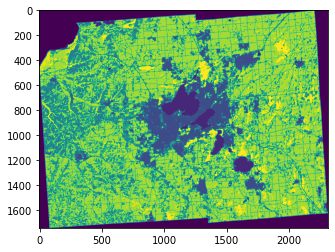

In [34]:
dane = gpd.read_file(url)
dane.plot()
from rasterio.mask import mask
matrix, _ = mask(land, dane.to_crs(land.crs)["geometry"], crop=True)
matrix = matrix[0]
import matplotlib.pyplot as plt
plt.imshow(matrix)

In [35]:
url_mil =  "https://tigerweb.geo.census.gov/arcgis/rest/services/TIGERweb/tigerWMS_Census2020/MapServer/82/query?where=NAME%3D%27Milwaukee+County%27&text=&objectIds=&time=&geometry=&geometryType=esriGeometryEnvelope&inSR=&spatialRel=esriSpatialRelIntersects&distance=&units=esriSRUnit_Foot&relationParam=&outFields=&returnGeometry=true&returnTrueCurves=false&maxAllowableOffset=&geometryPrecision=&outSR=&havingClause=&returnIdsOnly=false&returnCountOnly=false&orderByFields=&groupByFieldsForStatistics=&outStatistics=&returnZ=false&returnM=false&gdbVersion=&historicMoment=&returnDistinctValues=false&resultOffset=&resultRecordCount=&returnExtentOnly=false&datumTransformation=&parameterValues=&rangeValues=&quantizationParameters=&featureEncoding=esriDefault&f=geojson"

In [36]:
from matplotlib.colors import ListedColormap

c = np.zeros((256,3))
c[0] = [0.00000000000, 0.00000000000, 0.00000000000]
c[11] = [0.27843137255, 0.41960784314, 0.62745098039]
c[12] = [0.81960784314, 0.86666666667, 0.97647058824]
c[21] = [0.86666666667, 0.78823529412, 0.78823529412]
c[22] = [0.84705882353, 0.57647058824, 0.50980392157]
c[23] = [0.92941176471, 0.00000000000, 0.00000000000]
c[24] = [0.66666666667, 0.00000000000, 0.00000000000]
c[31] = [0.69803921569, 0.67843137255, 0.63921568628]
c[41] = [0.40784313726, 0.66666666667, 0.38823529412]
c[42] = [0.10980392157, 0.38823529412, 0.18823529412]
c[43] = [0.70980392157, 0.78823529412, 0.55686274510]
c[51] = [0.64705882353, 0.54901960784, 0.18823529412]
c[52] = [0.80000000000, 0.72941176471, 0.48627450980]
c[71] = [0.88627450980, 0.88627450980, 0.75686274510]
c[72] = [0.78823529412, 0.78823529412, 0.46666666667]
c[73] = [0.60000000000, 0.75686274510, 0.27843137255]
c[74] = [0.46666666667, 0.67843137255, 0.57647058824]
c[81] = [0.85882352941, 0.84705882353, 0.23921568628]
c[82] = [0.66666666667, 0.43921568628, 0.15686274510]
c[90] = [0.72941176471, 0.84705882353, 0.91764705882]
c[95] = [0.43921568628, 0.63921568628, 0.72941176471]
custom_cmap = ListedColormap(c)

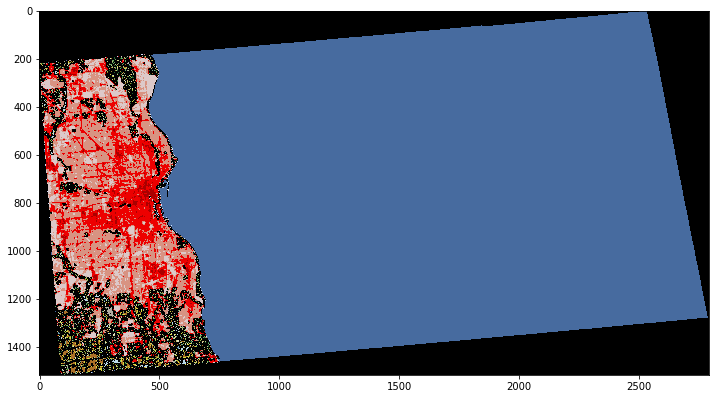

In [37]:
#Q13
matrix, _ = mask(land, gdf[gdf["NAME"] == "Milwaukee County"].to_crs(land.crs)["geometry"], crop=True)
matrix = matrix[0]
fig, ax = plt.subplots(figsize=(12,12))
plt.imshow(matrix, cmap=custom_cmap, vmin=0, vmax=255)

In [38]:
#q14
land_use = {"open_water": 11,
            "ice_snow": 12,
            "developed_open": 21,
            "developed_low": 22,
            "developed_med": 23,
            "developed_high": 24,
            "barren": 31,
            "deciduous": 41,
            "evergreen": 42,
            "mixed_forest": 43,
            "dwarf_scrub": 51,
            "shrub_scrub": 52,
            "grassland": 71,
            "sedge": 72,
            "lichens": 73,
            "moss": 74,
            "pasture": 81,
            "crops": 82,
            "woody_wetlands": 90,
            "herbacious_wetlands": 95}
(matrix == land_use["open_water"]).astype(int).sum() / (matrix != 0).astype(int).sum()

0.7963037455950543

In [39]:
cell_count = []
pop = []

for i in list(gdf["NAME"]):
    matrix, _ = mask(land, gdf[gdf["NAME"] == i].to_crs(land.crs)["geometry"], crop=True)
    matrix = matrix[0]
    water_cell_count = (matrix == land_use["open_water"]).astype(int).sum()
    cell_count.append(water_cell_count)
    population = gdf[gdf["NAME"] == i]["POP100"]
    pop.append(population)

Text(0, 0.5, 'pop')

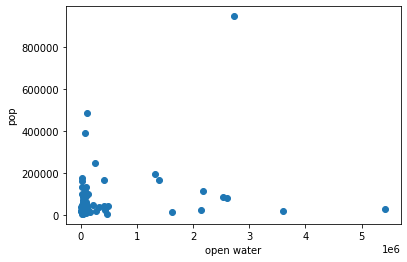

In [40]:
#q15
fig, ax = plt.subplots()
plt.scatter(x = cell_count, y = pop)
plt.xlabel("open water")
plt.ylabel("pop")

In [41]:
gdf_tracts = gpd.read_file("tracts.geojson")

In [42]:
develop_high = []
woody_wet = []
ever_green = []
develop_med = []
for i in list(gdf_tracts["GEOID"]):
    matrix, _ = mask(land, gdf_tracts[gdf_tracts["GEOID"] == i].to_crs(land.crs)["geometry"], crop=True)
    matrix = matrix[0]
    cell_count1 = (matrix == land_use["developed_high"]).astype(int).sum()
    cell_count2 = (matrix == land_use["woody_wetlands"]).astype(int).sum()
    cell_count3 = (matrix == land_use["evergreen"]).astype(int).sum()
    cell_count4 = (matrix == land_use["developed_med"]).astype(int).sum()
    develop_high.append(cell_count1)
    woody_wet.append(cell_count2)
    ever_green.append(cell_count3)
    develop_med.append(cell_count4)

In [43]:
gdf_tracts["developed_high"] = develop_high
gdf_tracts["woody_wet"] = woody_wet
gdf_tracts["ever_green"] = ever_green
gdf_tracts["developed_med"] = develop_med

In [44]:
gdf_tracts

,GEOID,POP100,geometry,developed_high,woody_wet,ever_green,developed_med
0,55001950204,1646,"POLYGON ((-90.02638 44.08721, -90.02628 44.086...",104,84766,36471,833
1,55009940002,4698,"POLYGON ((-88.15018 44.51202, -88.15011 44.509...",243,2317,7,1211
2,55061990000,0,"POLYGON ((-87.53727 44.33179, -87.53920 44.327...",0,0,0,0
3,55009020100,5817,"POLYGON ((-87.93753 44.67821, -87.93742 44.630...",337,26017,196,1971
4,55009010100,6506,"POLYGON ((-88.06825 44.45368, -88.06830 44.453...",174,79,0,1109
...,...,...,...,...,...,...,...
1537,55139003100,2046,"POLYGON ((-88.47454 44.19198, -88.47453 44.191...",299,40,0,467
1538,55079017900,2879,"POLYGON ((-87.91064 42.99520, -87.91063 42.995...",153,0,0,491
1539,55059000800,2763,"POLYGON ((-87.84574 42.60276, -87.84574 42.602...",200,0,0,748
1540,55025013700,7107,"POLYGON ((-89.57788 42.98135, -89.57789 42.980...",477,382,280,1799


In [45]:
train, test = train_test_split(gdf_tracts, random_state=320)

In [46]:
lm1 = LinearRegression()
lm1.fit(train[["developed_high", "developed_med"]], train["POP100"])
mean_score_model1 = cross_val_score(lm1, train[["developed_high", "developed_med"]], train["POP100"]).mean()
sd_score_model1 = cross_val_score(lm1, train[["developed_high", "developed_med"]], train["POP100"]).std()
mean_score_model1, sd_score_model1

(0.4186618136350333, 0.044919422629547415)

In [47]:
lm2 = LinearRegression()
lm2.fit(train[["woody_wet", "ever_green"]], train["POP100"])
mean_score_model2 = cross_val_score(lm2, train[["woody_wet", "ever_green"]], train["POP100"]).mean()
sd_score_model2 = cross_val_score(lm2, train[["woody_wet", "ever_green"]], train["POP100"]).std()
mean_score_model2, sd_score_model2

(0.016163312591497614, 0.009781481206714248)

Text(0, 0.5, 'R^2 Score')

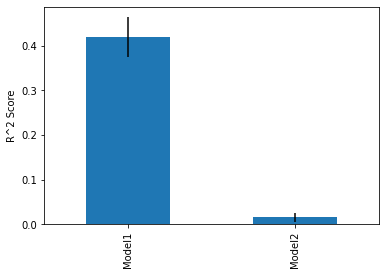

In [48]:
#q16
avg = pd.Series({"Model1": mean_score_model1, "Model2": mean_score_model2})
std = pd.Series({"Model1": sd_score_model1, "Model2": sd_score_model2})
ax = avg.plot.bar(yerr=std)
ax.set_ylabel("R^2 Score")

In [49]:
#q17

##comment
#I would suggest to use the model1 because (1) the score is relatively high in R^2, which means it is correlated tightly with
#the regression line. (2) The varience is relatively small accoss the scores, which means the model is not overfitting
#(3) The model is relatively simple because it trains the model only based on two features, which is eaiser for researcher
#to evaluate.

test_expected_varience = lm1.score(test[["developed_high", "developed_med"]], test["POP100"])
test_expected_varience

0.3689154829950113